In [1]:
import argparse
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
BATCH_SIZE = 16
EPOCHS = 300
Z_DIM = 2
LEARNING_RATE = 0.001

In [3]:
train_data = datasets.FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./data', train=False,
                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc21 = nn.Linear(500, Z_DIM)  # fc21 for mean of Z
        self.fc22 = nn.Linear(500, Z_DIM)  # fc22 for log variance of Z

        self.fc3 = nn.Linear(Z_DIM, 500)
        self.fc4 = nn.Linear(500, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        # I guess the reason for using logvar instead of std or var is that
        # the output of fc22 can be negative value (std and var should be positive)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        return mu + eps*std

    def decode(self, z):
        x = F.relu(self.fc3(z))
        x = torch.sigmoid(self.fc4(x))
        return x

    def forward(self, x):
        # x: [batch size, 1, 28, 28] -> x: [batch size, 784]
        x = x.view(-1, 784)

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        x = self.decode(z)
        return x, mu, logvar

In [5]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [6]:
def loss_function(output, x, mu, logvar):
    BCE = F.binary_cross_entropy(output, x.view(-1, 784), reduction='sum')
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

    return BCE + KLD

In [7]:
for epoch in tqdm(range(EPOCHS)):
    train_loss = 0

    for i, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.to(device)

        output, mu, logvar = model(data)

        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()

        cur_loss = loss.item()
        train_loss += cur_loss

        # if i % LOG_INTERVAL == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, i * len(data), len(train_loader.dataset),
        #         100.*i / len(train_loader),
        #         cur_loss/len(data)))

    print(f'====> Epoch: {epoch + 1} Average loss: {train_loss/len(train_loader.dataset)}')

  0%|          | 1/300 [00:18<1:30:57, 18.25s/it]

====> Epoch: 1 Average loss: 273.35098650309243


  1%|          | 2/300 [00:33<1:23:15, 16.76s/it]

====> Epoch: 2 Average loss: 266.10908373209634


  1%|          | 3/300 [00:49<1:20:45, 16.32s/it]

====> Epoch: 3 Average loss: 264.05622048746744


  1%|▏         | 4/300 [01:05<1:19:34, 16.13s/it]

====> Epoch: 4 Average loss: 262.8702656982422


  2%|▏         | 5/300 [01:21<1:18:46, 16.02s/it]

====> Epoch: 5 Average loss: 262.0101524983724


  2%|▏         | 6/300 [01:37<1:18:05, 15.94s/it]

====> Epoch: 6 Average loss: 261.3551596110026


  2%|▏         | 7/300 [01:52<1:17:24, 15.85s/it]

====> Epoch: 7 Average loss: 260.8870967610677


  3%|▎         | 8/300 [02:08<1:17:09, 15.86s/it]

====> Epoch: 8 Average loss: 260.4278523803711


  3%|▎         | 9/300 [02:24<1:17:19, 15.94s/it]

====> Epoch: 9 Average loss: 260.08750445556643


  3%|▎         | 10/300 [02:41<1:17:53, 16.11s/it]

====> Epoch: 10 Average loss: 259.84794957682294


  4%|▎         | 11/300 [02:57<1:17:29, 16.09s/it]

====> Epoch: 11 Average loss: 259.56269454345704


  4%|▍         | 12/300 [03:13<1:16:45, 15.99s/it]

====> Epoch: 12 Average loss: 259.3717002604167


  4%|▍         | 13/300 [03:28<1:16:10, 15.93s/it]

====> Epoch: 13 Average loss: 259.1490236775716


  5%|▍         | 14/300 [03:44<1:15:43, 15.89s/it]

====> Epoch: 14 Average loss: 258.9347760213216


  5%|▌         | 15/300 [04:00<1:15:36, 15.92s/it]

====> Epoch: 15 Average loss: 258.79925077311196


  5%|▌         | 16/300 [04:16<1:15:05, 15.86s/it]

====> Epoch: 16 Average loss: 258.62877630208334


  6%|▌         | 17/300 [04:32<1:14:43, 15.84s/it]

====> Epoch: 17 Average loss: 258.50225850830077


  6%|▌         | 18/300 [04:47<1:14:08, 15.77s/it]

====> Epoch: 18 Average loss: 258.28499728597006


  6%|▋         | 19/300 [05:03<1:13:54, 15.78s/it]

====> Epoch: 19 Average loss: 258.1985338216146


  7%|▋         | 20/300 [05:19<1:13:39, 15.79s/it]

====> Epoch: 20 Average loss: 258.0550339029948


  7%|▋         | 21/300 [05:35<1:13:26, 15.79s/it]

====> Epoch: 21 Average loss: 257.9567043619792


  7%|▋         | 22/300 [05:51<1:13:18, 15.82s/it]

====> Epoch: 22 Average loss: 257.8824079671224


  8%|▊         | 23/300 [06:07<1:13:10, 15.85s/it]

====> Epoch: 23 Average loss: 257.73562318115233


  8%|▊         | 24/300 [06:22<1:12:51, 15.84s/it]

====> Epoch: 24 Average loss: 257.65061384277345


  8%|▊         | 25/300 [06:38<1:12:48, 15.88s/it]

====> Epoch: 25 Average loss: 257.5945829833984


  9%|▊         | 26/300 [06:55<1:13:49, 16.17s/it]

====> Epoch: 26 Average loss: 257.51246506347655


  9%|▉         | 27/300 [07:11<1:13:23, 16.13s/it]

====> Epoch: 27 Average loss: 257.41434290364583


  9%|▉         | 28/300 [07:27<1:12:38, 16.02s/it]

====> Epoch: 28 Average loss: 257.3490969685872


 10%|▉         | 29/300 [07:43<1:12:27, 16.04s/it]

====> Epoch: 29 Average loss: 257.2796199951172


 10%|█         | 30/300 [07:59<1:12:00, 16.00s/it]

====> Epoch: 30 Average loss: 257.19944060872393


 10%|█         | 31/300 [08:15<1:11:43, 16.00s/it]

====> Epoch: 31 Average loss: 257.17543678792316


 11%|█         | 32/300 [08:31<1:11:22, 15.98s/it]

====> Epoch: 32 Average loss: 257.07491142578124


 11%|█         | 33/300 [08:47<1:11:02, 15.97s/it]

====> Epoch: 33 Average loss: 257.0289783894857


 11%|█▏        | 34/300 [09:03<1:10:33, 15.91s/it]

====> Epoch: 34 Average loss: 256.9935324503581


 12%|█▏        | 35/300 [09:19<1:10:14, 15.90s/it]

====> Epoch: 35 Average loss: 256.8780734375


 12%|█▏        | 36/300 [09:34<1:09:51, 15.88s/it]

====> Epoch: 36 Average loss: 256.8413161295573


 12%|█▏        | 37/300 [09:51<1:09:59, 15.97s/it]

====> Epoch: 37 Average loss: 256.80218533935545


 13%|█▎        | 38/300 [10:07<1:09:50, 15.99s/it]

====> Epoch: 38 Average loss: 256.78196334228517


 13%|█▎        | 39/300 [10:22<1:09:19, 15.94s/it]

====> Epoch: 39 Average loss: 256.77356157226563


 13%|█▎        | 40/300 [10:38<1:08:53, 15.90s/it]

====> Epoch: 40 Average loss: 256.66847174886067


 14%|█▎        | 41/300 [10:54<1:08:32, 15.88s/it]

====> Epoch: 41 Average loss: 256.6527120646159


 14%|█▍        | 42/300 [11:10<1:08:28, 15.92s/it]

====> Epoch: 42 Average loss: 256.60718486328125


 14%|█▍        | 43/300 [11:27<1:08:58, 16.10s/it]

====> Epoch: 43 Average loss: 256.5585185139974


 15%|█▍        | 44/300 [11:42<1:08:08, 15.97s/it]

====> Epoch: 44 Average loss: 256.4603973347982


 15%|█▌        | 45/300 [11:58<1:07:45, 15.94s/it]

====> Epoch: 45 Average loss: 256.5382468180338


 15%|█▌        | 46/300 [12:14<1:07:16, 15.89s/it]

====> Epoch: 46 Average loss: 256.45056475016275


 16%|█▌        | 47/300 [12:30<1:06:43, 15.82s/it]

====> Epoch: 47 Average loss: 256.377298819987


 16%|█▌        | 48/300 [12:46<1:06:51, 15.92s/it]

====> Epoch: 48 Average loss: 256.44825132649737


 16%|█▋        | 49/300 [13:01<1:06:15, 15.84s/it]

====> Epoch: 49 Average loss: 256.27362645670576


 17%|█▋        | 50/300 [13:17<1:05:55, 15.82s/it]

====> Epoch: 50 Average loss: 256.3349591349284


 17%|█▋        | 51/300 [13:33<1:05:29, 15.78s/it]

====> Epoch: 51 Average loss: 256.2731126139323


 17%|█▋        | 52/300 [13:49<1:05:38, 15.88s/it]

====> Epoch: 52 Average loss: 256.24860416666667


 18%|█▊        | 53/300 [14:05<1:06:03, 16.05s/it]

====> Epoch: 53 Average loss: 256.19766258951825


 18%|█▊        | 54/300 [14:21<1:05:45, 16.04s/it]

====> Epoch: 54 Average loss: 256.13990891927085


 18%|█▊        | 55/300 [14:37<1:05:24, 16.02s/it]

====> Epoch: 55 Average loss: 256.14512072347003


 19%|█▊        | 56/300 [14:53<1:05:05, 16.01s/it]

====> Epoch: 56 Average loss: 256.14548470052085


 19%|█▉        | 57/300 [15:09<1:04:43, 15.98s/it]

====> Epoch: 57 Average loss: 256.1001360107422


 19%|█▉        | 58/300 [15:25<1:04:20, 15.95s/it]

====> Epoch: 58 Average loss: 256.04585080159507


 20%|█▉        | 59/300 [15:41<1:04:00, 15.94s/it]

====> Epoch: 59 Average loss: 256.0310616088867


 20%|██        | 60/300 [15:57<1:03:54, 15.98s/it]

====> Epoch: 60 Average loss: 256.0070096069336


 20%|██        | 61/300 [16:13<1:03:37, 15.97s/it]

====> Epoch: 61 Average loss: 255.99084487711588


 21%|██        | 62/300 [16:29<1:03:12, 15.93s/it]

====> Epoch: 62 Average loss: 255.98496302490236


 21%|██        | 63/300 [16:45<1:02:40, 15.87s/it]

====> Epoch: 63 Average loss: 255.9824784342448


 21%|██▏       | 64/300 [17:02<1:03:48, 16.22s/it]

====> Epoch: 64 Average loss: 255.89702864583333


 22%|██▏       | 65/300 [17:18<1:03:15, 16.15s/it]

====> Epoch: 65 Average loss: 255.93576821695964


 22%|██▏       | 66/300 [17:34<1:02:46, 16.10s/it]

====> Epoch: 66 Average loss: 255.8462276204427


 22%|██▏       | 67/300 [17:50<1:02:22, 16.06s/it]

====> Epoch: 67 Average loss: 255.82377713216147


 23%|██▎       | 68/300 [18:06<1:02:11, 16.08s/it]

====> Epoch: 68 Average loss: 255.8113247721354


 23%|██▎       | 69/300 [18:22<1:02:03, 16.12s/it]

====> Epoch: 69 Average loss: 255.86676585286457


 23%|██▎       | 70/300 [18:38<1:01:18, 16.00s/it]

====> Epoch: 70 Average loss: 255.8238805460612


 24%|██▎       | 71/300 [18:54<1:00:52, 15.95s/it]

====> Epoch: 71 Average loss: 255.73377333984374


 24%|██▍       | 72/300 [19:09<1:00:35, 15.94s/it]

====> Epoch: 72 Average loss: 255.78247110595703


 24%|██▍       | 73/300 [19:26<1:00:46, 16.06s/it]

====> Epoch: 73 Average loss: 255.70141088460286


 25%|██▍       | 74/300 [19:42<1:01:11, 16.25s/it]

====> Epoch: 74 Average loss: 255.70819471435547


 25%|██▌       | 75/300 [19:59<1:01:35, 16.43s/it]

====> Epoch: 75 Average loss: 255.72860202636718


 25%|██▌       | 76/300 [20:16<1:01:51, 16.57s/it]

====> Epoch: 76 Average loss: 255.61898416748048


 26%|██▌       | 77/300 [20:33<1:02:10, 16.73s/it]

====> Epoch: 77 Average loss: 255.59723518473308


 26%|██▌       | 78/300 [20:50<1:02:00, 16.76s/it]

====> Epoch: 78 Average loss: 255.60721608072916


 26%|██▋       | 79/300 [21:07<1:01:57, 16.82s/it]

====> Epoch: 79 Average loss: 255.64322047526042


 27%|██▋       | 80/300 [21:24<1:01:45, 16.84s/it]

====> Epoch: 80 Average loss: 255.5738274536133


 27%|██▋       | 81/300 [21:41<1:01:08, 16.75s/it]

====> Epoch: 81 Average loss: 255.59401077880858


 27%|██▋       | 82/300 [21:57<1:00:34, 16.67s/it]

====> Epoch: 82 Average loss: 255.50922525634766


 28%|██▊       | 83/300 [22:15<1:01:22, 16.97s/it]

====> Epoch: 83 Average loss: 255.5163058227539


 28%|██▊       | 84/300 [22:31<1:00:15, 16.74s/it]

====> Epoch: 84 Average loss: 255.55641447347006


 28%|██▊       | 85/300 [22:47<59:13, 16.53s/it]  

====> Epoch: 85 Average loss: 255.52701287434897


 29%|██▊       | 86/300 [23:03<58:30, 16.41s/it]

====> Epoch: 86 Average loss: 255.51929037272134


 29%|██▉       | 87/300 [23:19<57:49, 16.29s/it]

====> Epoch: 87 Average loss: 255.41443041992187


 29%|██▉       | 88/300 [23:35<57:12, 16.19s/it]

====> Epoch: 88 Average loss: 255.50826552734375


 30%|██▉       | 89/300 [23:51<56:51, 16.17s/it]

====> Epoch: 89 Average loss: 255.45422287190755


 30%|███       | 90/300 [24:07<56:37, 16.18s/it]

====> Epoch: 90 Average loss: 255.46696191813152


 30%|███       | 91/300 [24:23<56:10, 16.13s/it]

====> Epoch: 91 Average loss: 255.46367576904296


 31%|███       | 92/300 [24:39<55:49, 16.10s/it]

====> Epoch: 92 Average loss: 255.34502177734376


 31%|███       | 93/300 [24:55<55:30, 16.09s/it]

====> Epoch: 93 Average loss: 255.4107377360026


 31%|███▏      | 94/300 [25:12<55:26, 16.15s/it]

====> Epoch: 94 Average loss: 255.36409942626952


 32%|███▏      | 95/300 [25:28<54:56, 16.08s/it]

====> Epoch: 95 Average loss: 255.36070732014974


 32%|███▏      | 96/300 [25:43<54:06, 15.91s/it]

====> Epoch: 96 Average loss: 255.39112818196614


 32%|███▏      | 97/300 [25:59<53:47, 15.90s/it]

====> Epoch: 97 Average loss: 255.35911876627605


 33%|███▎      | 98/300 [26:15<53:44, 15.96s/it]

====> Epoch: 98 Average loss: 255.36655257568358


 33%|███▎      | 99/300 [26:31<53:30, 15.97s/it]

====> Epoch: 99 Average loss: 255.34420638020833


 33%|███▎      | 100/300 [26:47<53:08, 15.94s/it]

====> Epoch: 100 Average loss: 255.3106032348633


 34%|███▎      | 101/300 [27:03<52:52, 15.94s/it]

====> Epoch: 101 Average loss: 255.33370166829428


 34%|███▍      | 102/300 [27:19<52:30, 15.91s/it]

====> Epoch: 102 Average loss: 255.32524600830078


 34%|███▍      | 103/300 [27:36<53:04, 16.17s/it]

====> Epoch: 103 Average loss: 255.25612260335288


 35%|███▍      | 104/300 [27:51<52:23, 16.04s/it]

====> Epoch: 104 Average loss: 255.2553485188802


 35%|███▌      | 105/300 [28:07<52:11, 16.06s/it]

====> Epoch: 105 Average loss: 255.23464451497395


 35%|███▌      | 106/300 [28:24<51:58, 16.07s/it]

====> Epoch: 106 Average loss: 255.22206910807293


 36%|███▌      | 107/300 [28:39<51:31, 16.02s/it]

====> Epoch: 107 Average loss: 255.2490048502604


 36%|███▌      | 108/300 [28:55<51:01, 15.94s/it]

====> Epoch: 108 Average loss: 255.17577154541016


 36%|███▋      | 109/300 [29:11<50:46, 15.95s/it]

====> Epoch: 109 Average loss: 255.1860680460612


 37%|███▋      | 110/300 [29:27<50:40, 16.00s/it]

====> Epoch: 110 Average loss: 255.2001071492513


 37%|███▋      | 111/300 [29:43<50:34, 16.05s/it]

====> Epoch: 111 Average loss: 255.23668870442708


 37%|███▋      | 112/300 [30:00<50:28, 16.11s/it]

====> Epoch: 112 Average loss: 255.15836934814453


 38%|███▊      | 113/300 [30:16<50:21, 16.16s/it]

====> Epoch: 113 Average loss: 255.12042091878254


 38%|███▊      | 114/300 [30:32<50:03, 16.15s/it]

====> Epoch: 114 Average loss: 255.21319439697265


 38%|███▊      | 115/300 [30:48<49:36, 16.09s/it]

====> Epoch: 115 Average loss: 255.0931462036133


 39%|███▊      | 116/300 [31:04<49:18, 16.08s/it]

====> Epoch: 116 Average loss: 255.08986094156901


 39%|███▉      | 117/300 [31:21<49:33, 16.25s/it]

====> Epoch: 117 Average loss: 255.05432509358724


 39%|███▉      | 118/300 [31:38<49:50, 16.43s/it]

====> Epoch: 118 Average loss: 255.1590447306315


 40%|███▉      | 119/300 [31:55<50:04, 16.60s/it]

====> Epoch: 119 Average loss: 255.1533472981771


 40%|████      | 120/300 [32:11<49:50, 16.62s/it]

====> Epoch: 120 Average loss: 255.04082994791668


 40%|████      | 121/300 [32:28<49:48, 16.69s/it]

====> Epoch: 121 Average loss: 255.06112943522135


 41%|████      | 122/300 [32:45<49:49, 16.79s/it]

====> Epoch: 122 Average loss: 255.03053486328125


 41%|████      | 123/300 [33:02<49:48, 16.88s/it]

====> Epoch: 123 Average loss: 255.0706608968099


 41%|████▏     | 124/300 [33:19<49:27, 16.86s/it]

====> Epoch: 124 Average loss: 255.03511315511068


 42%|████▏     | 125/300 [33:37<49:48, 17.07s/it]

====> Epoch: 125 Average loss: 255.0424124186198


 42%|████▏     | 126/300 [33:53<48:35, 16.76s/it]

====> Epoch: 126 Average loss: 254.9947300333659


 42%|████▏     | 127/300 [34:09<48:07, 16.69s/it]

====> Epoch: 127 Average loss: 255.00077967936198


 43%|████▎     | 128/300 [34:26<47:40, 16.63s/it]

====> Epoch: 128 Average loss: 255.0321428914388


 43%|████▎     | 129/300 [34:43<47:38, 16.71s/it]

====> Epoch: 129 Average loss: 255.02350103759767


 43%|████▎     | 130/300 [35:00<47:36, 16.80s/it]

====> Epoch: 130 Average loss: 254.9680442138672


 44%|████▎     | 131/300 [35:16<46:56, 16.66s/it]

====> Epoch: 131 Average loss: 254.94726761067707


 44%|████▍     | 132/300 [35:32<46:21, 16.55s/it]

====> Epoch: 132 Average loss: 254.98754557698567


 44%|████▍     | 133/300 [35:49<45:55, 16.50s/it]

====> Epoch: 133 Average loss: 254.93575153808592


 45%|████▍     | 134/300 [36:05<45:47, 16.55s/it]

====> Epoch: 134 Average loss: 254.9248284383138


 45%|████▌     | 135/300 [36:22<45:38, 16.60s/it]

====> Epoch: 135 Average loss: 254.90693236897786


 45%|████▌     | 136/300 [36:38<44:58, 16.46s/it]

====> Epoch: 136 Average loss: 254.93507118326824


 46%|████▌     | 137/300 [36:54<44:21, 16.33s/it]

====> Epoch: 137 Average loss: 254.94124780273438


 46%|████▌     | 138/300 [37:10<44:06, 16.33s/it]

====> Epoch: 138 Average loss: 254.93263829752604


 46%|████▋     | 139/300 [37:27<43:57, 16.38s/it]

====> Epoch: 139 Average loss: 254.8617853434245


 47%|████▋     | 140/300 [37:43<43:41, 16.38s/it]

====> Epoch: 140 Average loss: 254.9160199991862


 47%|████▋     | 141/300 [38:00<43:41, 16.49s/it]

====> Epoch: 141 Average loss: 254.92597435302736


 47%|████▋     | 142/300 [38:17<43:49, 16.64s/it]

====> Epoch: 142 Average loss: 254.8175238688151


 48%|████▊     | 143/300 [38:34<43:25, 16.60s/it]

====> Epoch: 143 Average loss: 254.92746013183594


 48%|████▊     | 144/300 [38:50<42:54, 16.50s/it]

====> Epoch: 144 Average loss: 254.7928682413737


 48%|████▊     | 145/300 [39:06<42:26, 16.43s/it]

====> Epoch: 145 Average loss: 254.8727508260091


 49%|████▊     | 146/300 [39:22<41:53, 16.32s/it]

====> Epoch: 146 Average loss: 254.78417715250652


 49%|████▉     | 147/300 [39:39<41:52, 16.42s/it]

====> Epoch: 147 Average loss: 254.82063582763672


 49%|████▉     | 148/300 [39:56<41:49, 16.51s/it]

====> Epoch: 148 Average loss: 254.80405797932943


 50%|████▉     | 149/300 [40:12<41:22, 16.44s/it]

====> Epoch: 149 Average loss: 254.84098342285156


 50%|█████     | 150/300 [40:28<41:01, 16.41s/it]

====> Epoch: 150 Average loss: 254.82247956136067


 50%|█████     | 151/300 [40:45<40:46, 16.42s/it]

====> Epoch: 151 Average loss: 254.78698135172527


 51%|█████     | 152/300 [41:01<40:41, 16.50s/it]

====> Epoch: 152 Average loss: 254.78283431396486


 51%|█████     | 153/300 [41:18<40:42, 16.62s/it]

====> Epoch: 153 Average loss: 254.7854098836263


 51%|█████▏    | 154/300 [41:35<40:40, 16.71s/it]

====> Epoch: 154 Average loss: 254.75218326009116


 52%|█████▏    | 155/300 [41:52<40:30, 16.76s/it]

====> Epoch: 155 Average loss: 254.76795309651692


 52%|█████▏    | 156/300 [42:09<40:13, 16.76s/it]

====> Epoch: 156 Average loss: 254.7764951497396


 52%|█████▏    | 157/300 [42:25<39:53, 16.74s/it]

====> Epoch: 157 Average loss: 254.75728080647787


 53%|█████▎    | 158/300 [42:42<39:42, 16.78s/it]

====> Epoch: 158 Average loss: 254.7577776570638


 53%|█████▎    | 159/300 [42:59<39:25, 16.78s/it]

====> Epoch: 159 Average loss: 254.71018661702473


 53%|█████▎    | 160/300 [43:16<39:15, 16.83s/it]

====> Epoch: 160 Average loss: 254.74977732747396


 54%|█████▎    | 161/300 [43:33<38:48, 16.75s/it]

====> Epoch: 161 Average loss: 254.6966471150716


 54%|█████▍    | 162/300 [43:49<38:17, 16.65s/it]

====> Epoch: 162 Average loss: 254.65216623535156


 54%|█████▍    | 163/300 [44:05<37:48, 16.56s/it]

====> Epoch: 163 Average loss: 254.69914149983725


 55%|█████▍    | 164/300 [44:22<37:22, 16.49s/it]

====> Epoch: 164 Average loss: 254.67252256266275


 55%|█████▌    | 165/300 [44:38<36:40, 16.30s/it]

====> Epoch: 165 Average loss: 254.6455388264974


 55%|█████▌    | 166/300 [44:54<36:27, 16.32s/it]

====> Epoch: 166 Average loss: 254.66725529378255


 56%|█████▌    | 167/300 [45:11<36:35, 16.51s/it]

====> Epoch: 167 Average loss: 254.67018778889974


 56%|█████▌    | 168/300 [45:28<36:29, 16.59s/it]

====> Epoch: 168 Average loss: 254.76087194417318


 56%|█████▋    | 169/300 [45:44<36:01, 16.50s/it]

====> Epoch: 169 Average loss: 254.65690021158855


 57%|█████▋    | 170/300 [46:00<35:30, 16.39s/it]

====> Epoch: 170 Average loss: 254.66795920003256


 57%|█████▋    | 171/300 [46:16<35:07, 16.34s/it]

====> Epoch: 171 Average loss: 254.66007605794272


 57%|█████▋    | 172/300 [46:34<35:26, 16.61s/it]

====> Epoch: 172 Average loss: 254.67711270751954


 58%|█████▊    | 173/300 [46:50<34:57, 16.52s/it]

====> Epoch: 173 Average loss: 254.66239662272136


 58%|█████▊    | 174/300 [47:06<34:34, 16.47s/it]

====> Epoch: 174 Average loss: 254.67696341145833


 58%|█████▊    | 175/300 [47:22<34:07, 16.38s/it]

====> Epoch: 175 Average loss: 254.6599418334961


 59%|█████▊    | 176/300 [47:38<33:38, 16.28s/it]

====> Epoch: 176 Average loss: 254.57753513590495


 59%|█████▉    | 177/300 [47:54<33:11, 16.19s/it]

====> Epoch: 177 Average loss: 254.61445119222006


 59%|█████▉    | 178/300 [48:10<32:51, 16.16s/it]

====> Epoch: 178 Average loss: 254.5809114420573


 60%|█████▉    | 179/300 [48:27<32:42, 16.22s/it]

====> Epoch: 179 Average loss: 254.57378666585288


 60%|██████    | 180/300 [48:43<32:21, 16.18s/it]

====> Epoch: 180 Average loss: 254.59436991780598


 60%|██████    | 181/300 [48:59<32:12, 16.24s/it]

====> Epoch: 181 Average loss: 254.6059878499349


 61%|██████    | 182/300 [49:16<31:58, 16.26s/it]

====> Epoch: 182 Average loss: 254.56210154622397


 61%|██████    | 183/300 [49:32<31:40, 16.24s/it]

====> Epoch: 183 Average loss: 254.57288128662108


 61%|██████▏   | 184/300 [49:48<31:21, 16.22s/it]

====> Epoch: 184 Average loss: 254.53243732096354


 62%|██████▏   | 185/300 [50:04<31:05, 16.22s/it]

====> Epoch: 185 Average loss: 254.54484606933593


 62%|██████▏   | 186/300 [50:21<30:54, 16.27s/it]

====> Epoch: 186 Average loss: 254.59728948160807


 62%|██████▏   | 187/300 [50:37<30:45, 16.34s/it]

====> Epoch: 187 Average loss: 254.55113400472004


 63%|██████▎   | 188/300 [50:53<30:26, 16.31s/it]

====> Epoch: 188 Average loss: 254.5094189453125


 63%|██████▎   | 189/300 [51:10<30:11, 16.32s/it]

====> Epoch: 189 Average loss: 254.52247875976562


 63%|██████▎   | 190/300 [51:26<29:59, 16.36s/it]

====> Epoch: 190 Average loss: 254.51207768554687


 64%|██████▎   | 191/300 [51:42<29:38, 16.32s/it]

====> Epoch: 191 Average loss: 254.5482275309245


 64%|██████▍   | 192/300 [51:58<29:11, 16.22s/it]

====> Epoch: 192 Average loss: 254.5524416829427


 64%|██████▍   | 193/300 [52:15<28:53, 16.20s/it]

====> Epoch: 193 Average loss: 254.5133920735677


 65%|██████▍   | 194/300 [52:31<28:34, 16.17s/it]

====> Epoch: 194 Average loss: 254.54159921875


 65%|██████▌   | 195/300 [52:47<28:15, 16.15s/it]

====> Epoch: 195 Average loss: 254.59462174886067


 65%|██████▌   | 196/300 [53:03<27:54, 16.10s/it]

====> Epoch: 196 Average loss: 254.45352399495442


 66%|██████▌   | 197/300 [53:19<27:39, 16.12s/it]

====> Epoch: 197 Average loss: 254.4660809407552


 66%|██████▌   | 198/300 [53:36<28:02, 16.49s/it]

====> Epoch: 198 Average loss: 254.47058421223957


 66%|██████▋   | 199/300 [53:52<27:30, 16.34s/it]

====> Epoch: 199 Average loss: 254.52095339762369


 67%|██████▋   | 200/300 [54:09<27:16, 16.36s/it]

====> Epoch: 200 Average loss: 254.50714052734375


 67%|██████▋   | 201/300 [54:25<26:52, 16.29s/it]

====> Epoch: 201 Average loss: 254.45313371988934


 67%|██████▋   | 202/300 [54:41<26:31, 16.24s/it]

====> Epoch: 202 Average loss: 254.46104477945963


 68%|██████▊   | 203/300 [54:57<26:06, 16.15s/it]

====> Epoch: 203 Average loss: 254.4337932861328


 68%|██████▊   | 204/300 [55:13<25:49, 16.14s/it]

====> Epoch: 204 Average loss: 254.366894921875


 68%|██████▊   | 205/300 [55:29<25:33, 16.14s/it]

====> Epoch: 205 Average loss: 254.53835995686848


 69%|██████▊   | 206/300 [55:45<25:10, 16.07s/it]

====> Epoch: 206 Average loss: 254.41190008544922


 69%|██████▉   | 207/300 [56:01<24:50, 16.03s/it]

====> Epoch: 207 Average loss: 254.40336018880208


 69%|██████▉   | 208/300 [56:17<24:42, 16.11s/it]

====> Epoch: 208 Average loss: 254.39645132649738


 70%|██████▉   | 209/300 [56:33<24:22, 16.07s/it]

====> Epoch: 209 Average loss: 254.46345818277996


 70%|███████   | 210/300 [56:49<24:06, 16.07s/it]

====> Epoch: 210 Average loss: 254.39438825276693


 70%|███████   | 211/300 [57:05<23:52, 16.10s/it]

====> Epoch: 211 Average loss: 254.3794792236328


 71%|███████   | 212/300 [57:22<23:39, 16.13s/it]

====> Epoch: 212 Average loss: 254.39975357259115


 71%|███████   | 213/300 [57:38<23:22, 16.12s/it]

====> Epoch: 213 Average loss: 254.37779196777345


 71%|███████▏  | 214/300 [57:54<23:04, 16.10s/it]

====> Epoch: 214 Average loss: 254.4596468017578


 72%|███████▏  | 215/300 [58:10<22:48, 16.10s/it]

====> Epoch: 215 Average loss: 254.39094591064452


 72%|███████▏  | 216/300 [58:26<22:29, 16.07s/it]

====> Epoch: 216 Average loss: 254.39829518229166


 72%|███████▏  | 217/300 [58:42<22:14, 16.07s/it]

====> Epoch: 217 Average loss: 254.386084370931


 73%|███████▎  | 218/300 [58:58<21:59, 16.09s/it]

====> Epoch: 218 Average loss: 254.33171380208333


 73%|███████▎  | 219/300 [59:14<21:47, 16.15s/it]

====> Epoch: 219 Average loss: 254.4997111328125


 73%|███████▎  | 220/300 [59:31<21:34, 16.19s/it]

====> Epoch: 220 Average loss: 254.34449357096355


 74%|███████▎  | 221/300 [59:47<21:16, 16.15s/it]

====> Epoch: 221 Average loss: 254.34083633219402


 74%|███████▍  | 222/300 [1:00:02<20:51, 16.04s/it]

====> Epoch: 222 Average loss: 254.39540678304036


 74%|███████▍  | 223/300 [1:00:18<20:34, 16.03s/it]

====> Epoch: 223 Average loss: 254.32312659912108


 75%|███████▍  | 224/300 [1:00:35<20:40, 16.32s/it]

====> Epoch: 224 Average loss: 254.36074216715494


 75%|███████▌  | 225/300 [1:00:51<20:13, 16.18s/it]

====> Epoch: 225 Average loss: 254.3331571858724


 75%|███████▌  | 226/300 [1:01:08<19:57, 16.18s/it]

====> Epoch: 226 Average loss: 254.38287318929036


 76%|███████▌  | 227/300 [1:01:24<19:42, 16.20s/it]

====> Epoch: 227 Average loss: 254.29948360595702


 76%|███████▌  | 228/300 [1:01:40<19:24, 16.18s/it]

====> Epoch: 228 Average loss: 254.34405704345704


 76%|███████▋  | 229/300 [1:01:56<19:04, 16.12s/it]

====> Epoch: 229 Average loss: 254.33700392252604


 77%|███████▋  | 230/300 [1:02:12<18:52, 16.17s/it]

====> Epoch: 230 Average loss: 254.34976086832683


 77%|███████▋  | 231/300 [1:02:28<18:31, 16.11s/it]

====> Epoch: 231 Average loss: 254.24295170898438


 77%|███████▋  | 232/300 [1:02:44<18:13, 16.09s/it]

====> Epoch: 232 Average loss: 254.40589842529297


 78%|███████▊  | 233/300 [1:03:00<17:55, 16.05s/it]

====> Epoch: 233 Average loss: 254.26629087320964


 78%|███████▊  | 234/300 [1:03:16<17:40, 16.07s/it]

====> Epoch: 234 Average loss: 254.34682280273438


 78%|███████▊  | 235/300 [1:03:32<17:24, 16.06s/it]

====> Epoch: 235 Average loss: 254.3026621866862


 79%|███████▊  | 236/300 [1:03:48<17:03, 15.99s/it]

====> Epoch: 236 Average loss: 254.27151317545574


 79%|███████▉  | 237/300 [1:04:04<16:46, 15.97s/it]

====> Epoch: 237 Average loss: 254.2535883666992


 79%|███████▉  | 238/300 [1:04:20<16:34, 16.04s/it]

====> Epoch: 238 Average loss: 254.2987259440104


 80%|███████▉  | 239/300 [1:04:36<16:20, 16.07s/it]

====> Epoch: 239 Average loss: 254.3056954711914


 80%|████████  | 240/300 [1:04:53<16:04, 16.08s/it]

====> Epoch: 240 Average loss: 254.2816403930664


 80%|████████  | 241/300 [1:05:09<15:49, 16.10s/it]

====> Epoch: 241 Average loss: 254.26181451416016


 81%|████████  | 242/300 [1:05:25<15:32, 16.08s/it]

====> Epoch: 242 Average loss: 254.31248881835938


 81%|████████  | 243/300 [1:05:41<15:16, 16.08s/it]

====> Epoch: 243 Average loss: 254.30775245768228


 81%|████████▏ | 244/300 [1:05:57<15:00, 16.09s/it]

====> Epoch: 244 Average loss: 254.26230607096355


 82%|████████▏ | 245/300 [1:06:13<14:46, 16.11s/it]

====> Epoch: 245 Average loss: 254.26920577799478


 82%|████████▏ | 246/300 [1:06:29<14:28, 16.08s/it]

====> Epoch: 246 Average loss: 254.21753087565105


 82%|████████▏ | 247/300 [1:06:45<14:10, 16.06s/it]

====> Epoch: 247 Average loss: 254.21483484700522


 83%|████████▎ | 248/300 [1:07:02<14:07, 16.29s/it]

====> Epoch: 248 Average loss: 254.21885599772136


 83%|████████▎ | 249/300 [1:07:18<13:52, 16.33s/it]

====> Epoch: 249 Average loss: 254.31987263997397


 83%|████████▎ | 250/300 [1:07:34<13:30, 16.21s/it]

====> Epoch: 250 Average loss: 254.22629993082683


 84%|████████▎ | 251/300 [1:07:50<13:11, 16.16s/it]

====> Epoch: 251 Average loss: 254.3104735961914


 84%|████████▍ | 252/300 [1:08:06<12:52, 16.08s/it]

====> Epoch: 252 Average loss: 254.2570187784831


 84%|████████▍ | 253/300 [1:08:22<12:36, 16.09s/it]

====> Epoch: 253 Average loss: 254.19805544026693


 85%|████████▍ | 254/300 [1:08:38<12:18, 16.05s/it]

====> Epoch: 254 Average loss: 254.21509724121094


 85%|████████▌ | 255/300 [1:08:54<11:57, 15.94s/it]

====> Epoch: 255 Average loss: 254.22845744222005


 85%|████████▌ | 256/300 [1:09:10<11:39, 15.90s/it]

====> Epoch: 256 Average loss: 254.19536916910806


 86%|████████▌ | 257/300 [1:09:26<11:25, 15.95s/it]

====> Epoch: 257 Average loss: 254.1860455037435


 86%|████████▌ | 258/300 [1:09:42<11:12, 16.02s/it]

====> Epoch: 258 Average loss: 254.16620963134767


 86%|████████▋ | 259/300 [1:09:58<10:58, 16.07s/it]

====> Epoch: 259 Average loss: 254.20870777994793


 87%|████████▋ | 260/300 [1:10:14<10:40, 16.02s/it]

====> Epoch: 260 Average loss: 254.16098779703776


 87%|████████▋ | 261/300 [1:10:30<10:26, 16.06s/it]

====> Epoch: 261 Average loss: 254.20406560465494


 87%|████████▋ | 262/300 [1:10:46<10:10, 16.06s/it]

====> Epoch: 262 Average loss: 254.1713732421875


 88%|████████▊ | 263/300 [1:11:02<09:55, 16.08s/it]

====> Epoch: 263 Average loss: 254.24162341715495


 88%|████████▊ | 264/300 [1:11:19<09:39, 16.10s/it]

====> Epoch: 264 Average loss: 254.1466788208008


 88%|████████▊ | 265/300 [1:11:35<09:22, 16.08s/it]

====> Epoch: 265 Average loss: 254.15918154296875


 89%|████████▊ | 266/300 [1:11:51<09:05, 16.06s/it]

====> Epoch: 266 Average loss: 254.18781662597655


 89%|████████▉ | 267/300 [1:12:07<08:48, 16.03s/it]

====> Epoch: 267 Average loss: 254.15487165120442


 89%|████████▉ | 268/300 [1:12:23<08:33, 16.05s/it]

====> Epoch: 268 Average loss: 254.14123111165364


 90%|████████▉ | 269/300 [1:12:39<08:16, 16.03s/it]

====> Epoch: 269 Average loss: 254.18983092447917


 90%|█████████ | 270/300 [1:12:54<07:59, 15.97s/it]

====> Epoch: 270 Average loss: 254.13355287679036


 90%|█████████ | 271/300 [1:13:10<07:41, 15.91s/it]

====> Epoch: 271 Average loss: 254.14413299153645


 91%|█████████ | 272/300 [1:13:26<07:26, 15.94s/it]

====> Epoch: 272 Average loss: 254.1630955444336


 91%|█████████ | 273/300 [1:13:42<07:11, 15.97s/it]

====> Epoch: 273 Average loss: 254.1084423461914


 91%|█████████▏| 274/300 [1:13:58<06:55, 15.97s/it]

====> Epoch: 274 Average loss: 254.15884364827474


 92%|█████████▏| 275/300 [1:14:14<06:39, 15.97s/it]

====> Epoch: 275 Average loss: 254.09941584065754


 92%|█████████▏| 276/300 [1:14:32<06:32, 16.36s/it]

====> Epoch: 276 Average loss: 254.14882935791016


 92%|█████████▏| 277/300 [1:14:48<06:13, 16.26s/it]

====> Epoch: 277 Average loss: 254.16691270751954


 93%|█████████▎| 278/300 [1:15:04<05:56, 16.19s/it]

====> Epoch: 278 Average loss: 254.21510710042318


 93%|█████████▎| 279/300 [1:15:20<05:39, 16.18s/it]

====> Epoch: 279 Average loss: 254.13211072998047


 93%|█████████▎| 280/300 [1:15:36<05:23, 16.17s/it]

====> Epoch: 280 Average loss: 254.13887620035808


 94%|█████████▎| 281/300 [1:15:52<05:07, 16.16s/it]

====> Epoch: 281 Average loss: 254.2007928914388


 94%|█████████▍| 282/300 [1:16:08<04:50, 16.12s/it]

====> Epoch: 282 Average loss: 254.22728602701824


 94%|█████████▍| 283/300 [1:16:24<04:34, 16.14s/it]

====> Epoch: 283 Average loss: 254.13266147054037


 95%|█████████▍| 284/300 [1:16:40<04:17, 16.08s/it]

====> Epoch: 284 Average loss: 254.10352428792316


 95%|█████████▌| 285/300 [1:16:56<04:00, 16.01s/it]

====> Epoch: 285 Average loss: 254.15303173014323


 95%|█████████▌| 286/300 [1:17:12<03:43, 15.97s/it]

====> Epoch: 286 Average loss: 254.1146898885091


 96%|█████████▌| 287/300 [1:17:28<03:27, 15.96s/it]

====> Epoch: 287 Average loss: 254.1338301961263


 96%|█████████▌| 288/300 [1:17:44<03:11, 15.96s/it]

====> Epoch: 288 Average loss: 254.07313389078777


 96%|█████████▋| 289/300 [1:18:00<02:55, 15.99s/it]

====> Epoch: 289 Average loss: 254.11905177408855


 97%|█████████▋| 290/300 [1:18:16<02:39, 15.95s/it]

====> Epoch: 290 Average loss: 254.15160873616537


 97%|█████████▋| 291/300 [1:18:32<02:23, 15.96s/it]

====> Epoch: 291 Average loss: 254.0959124226888


 97%|█████████▋| 292/300 [1:18:47<02:07, 15.89s/it]

====> Epoch: 292 Average loss: 254.08595238037108


 98%|█████████▊| 293/300 [1:19:03<01:51, 15.87s/it]

====> Epoch: 293 Average loss: 254.1486532755534


 98%|█████████▊| 294/300 [1:19:19<01:35, 15.87s/it]

====> Epoch: 294 Average loss: 254.04459006347656


 98%|█████████▊| 295/300 [1:19:35<01:19, 15.86s/it]

====> Epoch: 295 Average loss: 254.06395322265624


 99%|█████████▊| 296/300 [1:19:51<01:03, 15.85s/it]

====> Epoch: 296 Average loss: 254.10093126627604


 99%|█████████▉| 297/300 [1:20:07<00:47, 15.93s/it]

====> Epoch: 297 Average loss: 254.0398951212565


 99%|█████████▉| 298/300 [1:20:23<00:31, 15.95s/it]

====> Epoch: 298 Average loss: 254.04975529785156


100%|█████████▉| 299/300 [1:20:39<00:16, 16.04s/it]

====> Epoch: 299 Average loss: 254.05091294759114


100%|██████████| 300/300 [1:20:55<00:00, 16.19s/it]

====> Epoch: 300 Average loss: 254.0266337931315


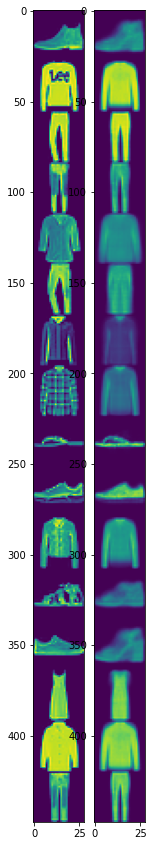

In [8]:
# Compress and reconstruct images

data, _ = next(iter(test_loader))
data = data.to(device)

recon_data, mu, logvar = model(data)

comparison = torch.cat([data[:8], recon_data.view(BATCH_SIZE, 1, 28, 28)[:8]]).cpu()

f, ax = plt.subplots(1, 2, figsize=(2, 18))
ax = ax.flatten()

ax[0].imshow(data.view(BATCH_SIZE * 28, 28).cpu().detach().numpy())
ax[1].imshow(recon_data.view(BATCH_SIZE * 28, 28).cpu().detach().numpy())
plt.show()

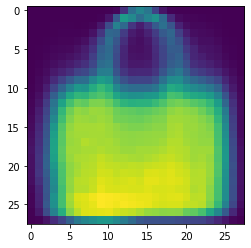

In [19]:
# Create a new image

sample = torch.randn(1, Z_DIM).to(device)
sample = model.decode(sample).cpu().view(28, 28).detach().numpy()

plt.imshow(sample)
plt.show()